In [4]:
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Reduce logging output.
tf.get_logger().setLevel('ERROR')
logging.set_verbosity(logging.ERROR)

# Getting started

## Data
We will try to solve the [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/) task [(Mass et al., 2011)](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as **negative** or **positive**.

In [5]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

train_df, test_df = download_and_load_datasets()
print(f'len train_df:{len(train_df)}')
train_df.head()

len train_df:25000


,sentence,sentiment,polarity
0,Absolutely the very first film that scared me ...,8,1
1,A lot of people don't think Branagh's Hamlet f...,10,1
2,Dr Tarr's Torture Dungeon is about a journalis...,4,0
3,"This movie is cold, bare truth. Often we think...",9,1
4,"I caught this movie on FX last night, and as I...",1,0


## Model
### Tensor Data

In order to use Tensorflow 2.1.0 we need to use td.data.Dateset. This objects are data containers useful to apply tensorflow pipelines.

In [7]:
validation_qty = int(len(train_df)*0.1)
train_ds = tf.data.Dataset.from_tensor_slices((list(train_df['sentence'].values)[validation_qty:], 
                                              list(train_df['polarity'].values)[validation_qty:])
                                            )

validate_ds = tf.data.Dataset.from_tensor_slices((list(train_df['sentence'].values)[:validation_qty], 
                                              list(train_df['polarity'].values)[:validation_qty])
                                            )


test_ds = tf.data.Dataset.from_tensor_slices((list(test_df['sentence'].values), 
                                              list(test_df['polarity'].values))
                                            )
train_examples_batch, train_labels_batch = next(iter(train_ds.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'I remember following the case of Andre Chicatillo in the newspapers while I was living in South Africa. They had photos of him sitting in his cage while being prosecuted in court. Not, as it turned out, to protect the court members, but to protect him from the public. This was fascinating, albeit morbid, reading. I later heard that a film had been made by HBO about the case, but it was made for American TV. Bummed! Strangely, CITIZEN X got a limited cinematic release in South Africa. I charged down to the local Ster Kinekor complex and duly bought a ticket (I was alone; my girlfriend at the time was only interested in the likes of STEEL MAGNOLIAS and FRIED GREEN TOMATOES). Wow! What a brilliant film. Why wasn\'t it released to a wider audience? Had it not been made for TV, it could have got an Oscar nomination or 2. There is no way to spoil the ending; who the killer is is never kept from the audience. Jeffrey DeMunn portrays a tru

### Feature columns

TF-Hub provides a [feature column](https://www.tensorflow.org/hub/api_docs/python/hub/text_embedding_column.md) that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). For the purpose of this tutorial, the most important facts are:

* The module takes **a batch of sentences in a 1-D tensor of strings** as input.
* The module is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string)
#hub_layer(train_examples_batch[:1])

### DNN Classifier

For classification we can use a DNN Classifier.

In [14]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * Tensor("inputs:0", shape=(None,), dtype=string)
    * False
    * None
  Keyword arguments: {}

Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/0'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/1'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/2')]
    * True
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids')]
 

ValueError: in converted code:

    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_hub/keras_layer.py:173 call  *
        result = smart_cond.smart_cond(training,
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/framework/smart_cond.py:56 smart_cond
        return false_fn()
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/saved_model/load.py:438 _call_attribute
        return instance.__call__(*args, **kwargs)
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py:568 __call__
        result = self._call(*args, **kwds)
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py:606 _call
        results = self._stateful_fn(*args, **kwds)
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py:2362 __call__
        graph_function, args, kwargs = self._maybe_define_function(args, kwargs)
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py:2703 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/eager/function.py:2593 _create_graph_function
        capture_by_value=self._capture_by_value),
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/framework/func_graph.py:978 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/eager/def_function.py:439 wrapped_fn
        return weak_wrapped_fn().__wrapped__(*args, **kwds)
    /home/chanchus/developments/movies_classifier/venv/lib/python3.6/site-packages/tensorflow_core/python/saved_model/function_deserialization.py:262 restored_function_body
        "\n\n".join(signature_descriptions)))

    ValueError: Could not find matching function to call loaded from the SavedModel. Got:
      Positional arguments (3 total):
        * Tensor("inputs:0", shape=(None,), dtype=string)
        * False
        * None
      Keyword arguments: {}
    
    Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (3 total):
        * [TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/0'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/1'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/2')]
        * True
        * None
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (3 total):
        * [TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids')]
        * True
        * None
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (3 total):
        * [TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids')]
        * False
        * None
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (3 total):
        * [TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/0'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/1'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/2')]
        * False
        * None
      Keyword arguments: {}


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training

Train the estimator for a reasonable amount of steps.

# Prediction

Run predictions for both training and test set.

In [ ]:
history = model.fit(train_ds.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validate_ds.batch(512),
                    verbose=1)

In [125]:
results = model.evaluate(test_ds.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.5662 - accuracy: 0.8698
loss: 0.566
accuracy: 0.870


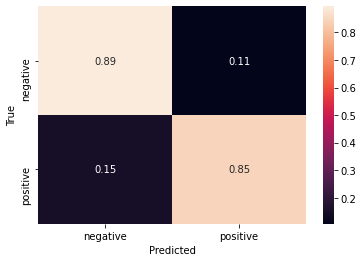

In [126]:
LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
cm = tf.math.confusion_matrix(test_df["polarity"], 
                              model.predict(test_ds.batch(512)) > 0.5)

# Normalize the confusion matrix so that each row sums to 1.
cm = tf.cast(cm, dtype=tf.float32)
cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

In [127]:
model.predict(['It was great'])

array([[0.98417956]], dtype=float32)